# Fine Tuning BERT Model

Fine-tuning a pre-trained BERT model for the purpose of evaluating our baseline and main model for text style transfer

**Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification, AutoModelForQuestionAnswering, AutoTokenizer
from torch.utils.data import DataLoader, Dataset
import torch
import warnings
from datasets import DatasetDict, Dataset, load_from_disk

warnings.filterwarnings('ignore')

/common/home/rsv39/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Data Preparation** 

In [2]:
folder_path = '../../data/seq2seq'
# Load the dataset from disk
seq2seq_dataset = load_from_disk(folder_path)

# Loading Datasets
train_dataset = seq2seq_dataset['train']  
eval_dataset = seq2seq_dataset['dev']  
test_dataset = seq2seq_dataset['test']

def create_bert_dataset(dataset):
    texts = []
    labels = []  # 1 for subjective, 0 for neutral

    for item in dataset:
        texts.append(item['source'])
        labels.append(1)  # Assuming 'source' is subjective
        texts.append(item['target'])
        labels.append(0)  # Assuming 'target' is neutralized

    return texts, labels

train_texts, train_labels = create_bert_dataset(train_dataset)
test_texts, test_labels = create_bert_dataset(test_dataset)

**Tokenization**

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_data(texts, labels, max_length=128):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels

train_inputs, train_masks, train_labels = tokenize_data(train_texts, train_labels)
test_inputs, test_masks, test_labels = tokenize_data(test_texts, test_labels)


**Data Loader Setup**

In [4]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert the lists into TensorDatasets
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
test_dataset = TensorDataset(test_inputs, test_masks, test_labels)

# Create DataLoaders
batch_size = 32

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
)

test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=batch_size
)


**Model Initialisation and Training**

In [5]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,  # Binary classification: subjective vs neutral
    output_attentions=False,
    output_hidden_states=False,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Then move the model to the device
model.to(device)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [6]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 4  

# Total number of training steps
total_steps = len(train_dataloader) * epochs  

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [7]:
for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    for step, batch in enumerate(train_dataloader):
        # Move batch to the device
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}, Average Training Loss: {avg_train_loss}')


Epoch 1, Average Training Loss: 0.5438333685771365
Epoch 2, Average Training Loss: 0.46264882680267244
Epoch 3, Average Training Loss: 0.40182393875083167
Epoch 4, Average Training Loss: 0.34943177647833606


As during fine-tuning, the loss was not plotted, it was hardcoded to generate a plot to visualize the Average training loss printed 2 cells above

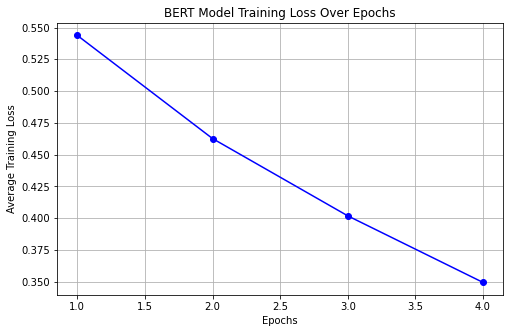

In [1]:
import matplotlib.pyplot as plt

# Epochs and their corresponding average training loss values
epochs = [1, 2, 3, 4]
avg_training_loss = [0.5438333685771365, 0.46264882680267244, 0.40182393875083167, 0.34943177647833606]

# Creating the plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, avg_training_loss, marker='o', linestyle='-', color='blue')
plt.title('BERT Model Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Average Training Loss')
plt.grid(True)
plt.show()


In [8]:
# Define a path where you want to save the model
model_path = "../../data/bert_finetuned/"

# Save the model
model.save_pretrained(model_path)

# Save the tokenizer associated with the model
tokenizer.save_pretrained(model_path)


('seq2seq/bert_model/tokenizer_config.json',
 'seq2seq/bert_model/special_tokens_map.json',
 'seq2seq/bert_model/vocab.txt',
 'seq2seq/bert_model/added_tokens.json')